In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#import deep learning libraries and other needed libraries
from keras import Sequential
from keras.layers import Flatten, Dense, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import Adam, SGD

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# from scipy import signal
# from scipy.signal import butter, sosfilt, sosfreqz

In [ ]:
# load dataset
train_data = pd.read_csv('/content/drive/My Drive/592TopicsDataScience/Final Project/test.csv')
train_data.columns = ["Time", "ECG", "Ax", "Ay", "Az"]
train_data.head()

,Time,ECG,Ax,Ay,Az
0,0.008333,134.76,0.22310,-0.15131,0.87346
1,0.016667,117.64,0.21813,-0.15153,0.87047
2,0.025000,144.96,0.21896,-0.15314,0.85289
3,0.033333,160.57,0.21804,-0.15625,0.86721
4,0.041667,177.87,0.21802,-0.15437,0.87482


In [ ]:
print("Shape of Training data: ",train_data.shape)
train_data.info()
# train_data["ECG"].value_counts()

Shape of Training data:  (335991, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 335991 entries, 0 to 335990
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    335991 non-null  float64
 1   ECG     335991 non-null  float64
 2   Ax      335991 non-null  float64
 3   Ay      335991 non-null  float64
 4   Az      335991 non-null  float64
dtypes: float64(5)
memory usage: 12.8 MB


In [ ]:
sample_freq = 120
total_samples = train_data.shape[0]
total_set_samples = int(np.floor(train_data.shape[0]/sample_freq)*sample_freq)
print("Sampling Frequency: {}\n Total Samples: {}\n Total Set Samples: {}".format(sample_freq,total_samples,total_set_samples))

Sampling Frequency: 120
 Total Samples: 335991
 Total Set Samples: 335880


In [ ]:
# data preprocessing

X_i=train_data[["Ax", "Ay", "Az"]].to_numpy()
X_i=X_i[48:]
Y_i=train_data[["ECG"]].to_numpy()
Y_i=Y_i[:-48]
time_stamp = train_data[["Time"]].to_numpy()

validation_samples = int(0.20* total_samples)
print(validation_samples)

X_train, X_test, y_train, y_test = X_i[:-validation_samples],X_i[-validation_samples:],Y_i[:-validation_samples],Y_i[-validation_samples:],

print("X_train shape: {}".format(X_train.shape))
print("y_train shape: {}".format(y_train.shape))

total_train_samples = X_train.shape[0]
print("X_test shape: {}".format(X_test.shape))
print("y_test shape: {}".format(y_test.shape))

total_val_samples = X_test.shape[0]

time_stamp_v = time_stamp[-validation_samples:]

67198
X_train shape: (268745, 3)
y_train shape: (268745, 1)
X_test shape: (67198, 3)
y_test shape: (67198, 1)


In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
Y_train_scaled = scaler.fit_transform(y_train)
X_test_scaled = scaler.fit_transform(X_test)
Y_test_scaled = scaler.fit_transform(y_test)

# create training data for NN
X,Y,Xt,Yt,tm = [],[],[],[],[]
stride = 60
for i in range(0,total_train_samples-stride):
  X.append(X_train_scaled[i:i+stride])
  Y.append(Y_train_scaled[i+stride-1])

for i in range(0,total_val_samples-stride):
  Xt.append(X_test_scaled[i:i+stride])
  Yt.append(Y_test_scaled[i+stride-1])
  tm.append(time_stamp_v[i+stride-1])

TM = np.array(tm)
X = np.array(X)
print("Input X shape:",X.shape)
Y = np.array(Y)
# Y = np.array(Y).reshape(-1,1,sample_freq)
print("Input Y shape:",Y.shape)

print("# of sets: {}\n# of timesteps: {}\n# features: {}\n".format(X.shape[0],X.shape[1],X.shape[2]))

# sets,timesteps,features,outputs = X.shape[0],X.shape[1],X.shape[2],Y.shape[2]
batch_size=64


Xt = np.array(Xt)
Yt = np.array(Yt)

print("Test X shape:",Xt.shape)
print("Test Y shape:",Yt.shape)
# Y = np.median(Y,axis=2)
# print("Input Y shape:",Y.shape)
# Y = np.array(Y).reshape(-1,1,120)

X = X.reshape(-1,stride,3,1)
Xt = Xt.reshape(-1,stride,3,1)

Input X shape: (268685, 60, 3)
Input Y shape: (268685, 1)
# of sets: 268685
# of timesteps: 60
# features: 3

Test X shape: (67138, 60, 3)
Test Y shape: (67138, 1)


In [ ]:
# build model
model = Sequential()
model.add(Conv2D(60, (5, 1), activation = 'relu', input_shape = X[0].shape))
model.add(Conv2D(60, (5, 1), activation = 'relu', input_shape = X[0].shape))
model.add(Flatten())
model.add(Dense(250, activation = 'relu'))
model.add(Dense(250, activation = 'relu'))
model.add(Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 56, 3, 60)         360       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 52, 3, 60)         18060     
_________________________________________________________________
flatten (Flatten)            (None, 9360)              0         
_________________________________________________________________
dense (Dense)                (None, 250)               2340250   
_________________________________________________________________
dense_1 (Dense)              (None, 250)               62750     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 251       
Total params: 2,421,671
Trainable params: 2,421,671
Non-trainable params: 0
______________________________________________

In [ ]:
# fit model
model.compile(optimizer=Adam(learning_rate = 0.001), loss = 'mse', metrics = ['accuracy'])
history=model.fit(X,Y,batch_size=batch_size,epochs=30,verbose=1,validation_data=(Xt, Yt))

Epoch 1/30
4199/4199 [==============================] - 22s 3ms/step - loss: 0.7197 - accuracy: 0.0000e+00 - val_loss: 0.7236 - val_accuracy: 0.0000e+00
Epoch 2/30
4199/4199 [==============================] - 15s 4ms/step - loss: 0.3880 - accuracy: 0.0000e+00 - val_loss: 0.5911 - val_accuracy: 0.0000e+00
Epoch 3/30
4199/4199 [==============================] - 15s 4ms/step - loss: 0.3110 - accuracy: 0.0000e+00 - val_loss: 0.8121 - val_accuracy: 0.0000e+00
Epoch 4/30
4199/4199 [==============================] - 15s 4ms/step - loss: 0.2434 - accuracy: 0.0000e+00 - val_loss: 0.8563 - val_accuracy: 0.0000e+00
Epoch 5/30
4199/4199 [==============================] - 14s 3ms/step - loss: 0.1976 - accuracy: 0.0000e+00 - val_loss: 0.8396 - val_accuracy: 0.0000e+00
Epoch 6/30
4199/4199 [==============================] - 15s 3ms/step - loss: 0.1620 - accuracy: 0.0000e+00 - val_loss: 0.8314 - val_accuracy: 0.0000e+00
Epoch 7/30
4199/4199 [==============================] - 15s 4ms/step - loss: 0.141

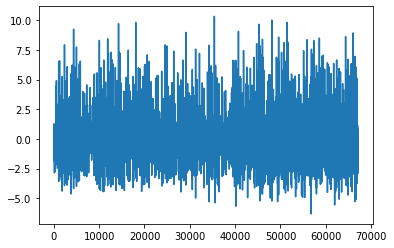

In [ ]:
# prediction
y1t = model.predict(Xt)
plt.figure()
plt.plot(y1t[:])

In [ ]:
# save the data
y_pred = scaler.inverse_transform(y1t)
y_gt = scaler.inverse_transform(Yt)
data_array = np.hstack((TM,y_pred,y_gt))
np.savetxt("predECE592FCNN2D.csv", data_array, delimiter=',', header="Time,ECG_pred,ECG_GT", comments="")